In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

from sklearn.model_selection import train_test_split

import uproot
import awkward as ak

In [2]:
# Function to calculate weights analytically

def weight_fn(xx1, xx2, xx3, phi, costh):
    weight = 1. + xx1 * costh * costh + 2. * xx2 * costh * np.sqrt(1. - costh * costh) * np.cos(phi) + 0.5 * xx3 * (1. - costh * costh)* np.cos(2. * phi)
    return weight / (1. + costh * costh)

In [3]:
# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
def plot_hist(X0, X1, weight0, weight1, weights, bins):
    # Create a figure and gridspec
    fig = plt.figure()
    gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])

    # Create the subplots with different sizes
    ax0 = plt.subplot(gs[0, 0])  # Subplot with size (1, 1)
    ax1 = plt.subplot(gs[1, 0])  # Subplot with size (1, 2)
    
    ax0.hist(X0, bins=bins, alpha=0.5, label=r'$\lambda, \mu, \nu = {}, {}, {}$'.format(lambda0, mu0, nu0), weights=weight0)
    ax0.hist(X0, bins=bins, label=r'$\lambda, \mu, \nu = {}, {}, {}$ weighted'.format(lambda0, mu0, nu0), weights=weights* weight0, histtype='step', color='k')
    ax0.hist(X1, bins=bins, alpha=0.5, label=r'$\lambda, \mu, \nu = {}, {}, {}$'.format(lambda1, mu1, nu1), weights=weight1)
    ax0.legend(frameon=False)

    counts0, _ = np.histogram(X0, bins, weights=weight1)
    counts1, _ = np.histogram(X1, bins, weights=weight0*weights)

    yerr = np.sqrt((counts0* counts1 + counts0* counts0)/(counts1* counts1* counts1))
    print(yerr.shape)
    cent = [bins[i] + (bins[i+1] - bins[i])/2. for i in range(30)]

    ax1.errorbar(cent, counts1/counts0, yerr=yerr, fmt="o")
    ax1.set_ylabel("Ratio")

    # Adjust spacing between subplots
    plt.tight_layout()
    
    # Show the figure
    plt.show()

# Reweighting with Classifiers

Neural network-based classifiers can be used to calculate weights between two distributions. In this particular example, we calculate the weights for two simulated Monte Carlo (MC) events. The details of this method are explained in [arXiv:2007.11586 [hep-ph]](https://arxiv.org/abs/2007.11586).

Let's assume that $f(x)$ represents the output of a neural network trained to classify two and MC distributions. In this case, the weights can be calculated using the following equation:

$$
w = \frac{f(x)}{1 - f(x)}
$$

Let's define a neural network with 3 hidden layers, each consisting of 32 nodes. All the hidden layers will be activated using the `ReLU` activation function, and the final output layer will be activated using the `Sigmoid` activation function.

In [5]:
class Net(nn.Module):
    def __init__(self, input_dim: int = 1, output_dim: int = 1, hidden_dim: int = 32):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim, bias=True)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim, bias=True)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim, bias=True)
        self.fc4 = nn.Linear(hidden_dim, output_dim, bias=True)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.sigmoid(self.fc4(x))
        return x

In [6]:
# Load E906 messy MC data

batch_size = 1000
n_events = 10**6

lambda0, mu0, nu0 = 0.9, -0.1, 0.3
lambda1, mu1, nu1 = 0.9, -0.1, 0.1

tree = uproot.open("BMFData.root:save")
events = tree.arrays(["mass", "pT", "xF", "phi", "costh", "true_phi", "true_costh"]).to_numpy()[:2*n_events]

data_array = np.array([list(record) for record in events])

events0, events1 = train_test_split(data_array, test_size=0.5, shuffle=True)

X0 = [(phi, costh) for phi, costh in zip(events0[:, 3], events0[:, 4])]
X1 = [(phi, costh) for phi,costh in zip(events1[:, 3], events1[:, 4])]

weight0 = [weight_fn(lambda0, mu0, nu0, phi, costh) for phi, costh in zip(events0[:, 5], events0[:, 6])]
weight1 = [weight_fn(lambda1, mu1, nu1, phi, costh) for phi, costh in zip(events1[:, 5], events1[:, 6])]

Y0 = np.zeros(n_events)
Y1 = np.ones(n_events)

X = np.concatenate((X0, X1))
Y = np.concatenate((Y0, Y1)).reshape(-1, 1)
weight = np.concatenate((weight0, weight1)).reshape(-1, 1)

# Convert to pytorch tensor
X_tensor = torch.from_numpy(X).float()
Y_tensor = torch.from_numpy(Y).float()
W_tensor = torch.from_numpy(weight).float()

# Train test split
X_train, X_test, Y_train, Y_test, W_train, W_test = train_test_split(X_tensor, Y_tensor, W_tensor, test_size=0.4, shuffle=True)

# Create dataset and data loader
train_dataset = TensorDataset(X_train, Y_train, W_train)
test_dataset = TensorDataset(X_test, Y_test, W_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [7]:
# Custom loss function
class NetLoss(nn.Module):
    def __init__(self):
        super(NetLoss, self).__init__()
        
    def forward(self, outputs, targets, weights):
        criterion = nn.BCELoss(reduction="none")
        loss = criterion(outputs, targets)
        weighted_loss = loss* weights
        return weighted_loss.mean()

In [8]:
# Create the model
model = Net(input_dim = 2)

In [9]:
criterion = NetLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [10]:
# Move the model to GPU if available
model = model.to(device=device)

In [11]:
# Model summary
print("using device : {}".format(device))
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(model)
print('total trainable params: {}'.format(total_trainable_params))

using device : cpu
Net(
  (fc1): Linear(in_features=2, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)
total trainable params: 2241


In [12]:
# Train step
def train_model(model, train_loader, test_loader, criterion, optimizer, device, epochs, early_stopping_patience):
    best_loss = float('inf')
    best_model_weights = None
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for batch_inputs, batch_labels, batch_weights in train_loader:
            batch_inputs = batch_inputs.to(device)
            batch_labels = batch_labels.to(device)
            batch_weights = batch_weights.to(device)

            optimizer.zero_grad()
            outputs = model(batch_inputs)
            loss = criterion(outputs, batch_labels, batch_weights)

            loss.backward()
            optimizer.step()
            running_loss += loss.item() * batch_inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)

        # Evaluation
        model.eval()
        with torch.no_grad():
            running_loss = 0.0
            for batch_inputs, batch_labels, batch_weights in test_loader:
                batch_inputs = batch_inputs.to(device)
                batch_labels = batch_labels.to(device)
                batch_weights = batch_weights.to(device)

                outputs = model(batch_inputs)
                loss = criterion(outputs, batch_labels, batch_weights)

                running_loss += loss.item() * batch_inputs.size(0)

            validation_loss = running_loss / len(test_loader.dataset)

            print("Epoch {}: Train Loss = {:.4f}, Test Loss = {:.4f}".format(epoch + 1, epoch_loss, validation_loss))

            # Check for early stopping
            if validation_loss < best_loss:
                best_loss = validation_loss
                best_model_weights = model.state_dict()
                patience_counter = 0
            else:
                patience_counter += 1

            if patience_counter >= early_stopping_patience:
                print("Early stopping at epoch {}".format(epoch))
                break

    return best_model_weights

In [13]:
def reweight_fn(model, X_val):
    # Move the model to CPU for evaluation
    model = model.to(torch.device("cpu"))

    model.eval()
    with torch.no_grad():
        preds = model(torch.Tensor(X_val)).detach().numpy().ravel()
        weights = preds / (1.0 - preds)
    return weights

In [14]:
epochs = 2000
early_stopping_patience = 50

# Compile the train function
opt_train = torch.compile(train_model, mode="max-autotune")

best_model_weights = opt_train(model, train_loader, test_loader, criterion, optimizer, device, epochs, early_stopping_patience)

Epoch 1: Train Loss = 0.6969, Test Loss = 0.6969
Epoch 2: Train Loss = 0.6968, Test Loss = 0.6968
Epoch 3: Train Loss = 0.6968, Test Loss = 0.6968
Epoch 4: Train Loss = 0.6968, Test Loss = 0.6968
Epoch 5: Train Loss = 0.6968, Test Loss = 0.6968
Epoch 6: Train Loss = 0.6968, Test Loss = 0.6968
Epoch 7: Train Loss = 0.6968, Test Loss = 0.6968
Epoch 8: Train Loss = 0.6968, Test Loss = 0.6968
Epoch 9: Train Loss = 0.6968, Test Loss = 0.6968
Epoch 10: Train Loss = 0.6968, Test Loss = 0.6968
Epoch 11: Train Loss = 0.6968, Test Loss = 0.6968
Epoch 12: Train Loss = 0.6968, Test Loss = 0.6968
Epoch 13: Train Loss = 0.6968, Test Loss = 0.6967
Epoch 14: Train Loss = 0.6968, Test Loss = 0.6968
Epoch 15: Train Loss = 0.6968, Test Loss = 0.6968
Epoch 16: Train Loss = 0.6967, Test Loss = 0.6968
Epoch 17: Train Loss = 0.6967, Test Loss = 0.6968
Epoch 18: Train Loss = 0.6967, Test Loss = 0.6968
Epoch 19: Train Loss = 0.6967, Test Loss = 0.6967
Epoch 20: Train Loss = 0.6967, Test Loss = 0.6968
Epoch 21:

Process ForkProcess-6:
Process ForkProcess-5:
Process ForkProcess-8:
Process ForkProcess-1:
Process ForkProcess-2:
Process ForkProcess-4:
Process ForkProcess-3:
Process ForkProcess-7:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/dinupa/mambaforge/envs/pytorch2.0/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/Users/dinupa/mambaforge/envs/pytorch2.0/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/Users/dinupa/mambaforge/envs/pytorch2.0/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/Users/dinupa/mambaforge/envs/pytorch2.0/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "

In [15]:
# Load the best model weights
model.load_state_dict(best_model_weights)

X0 = np.array(X0)
X1 = np.array(X1)
weight0 = np.array(weight0)
weight1 = np.array(weight1)

weights = reweight_fn(model, torch.Tensor(X0))

(30,)


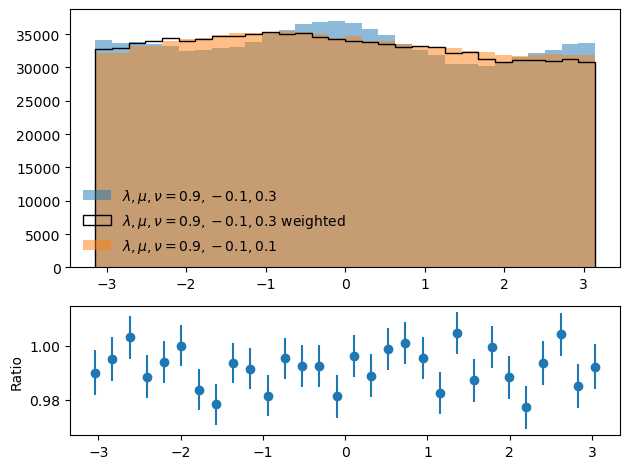

In [16]:
bins = np.linspace(-np.pi, np.pi, 31)

plot_hist(X0[:, 0], X1[:, 0], weight0=weight0, weight1=weight1, weights=weights, bins=bins)

(30,)


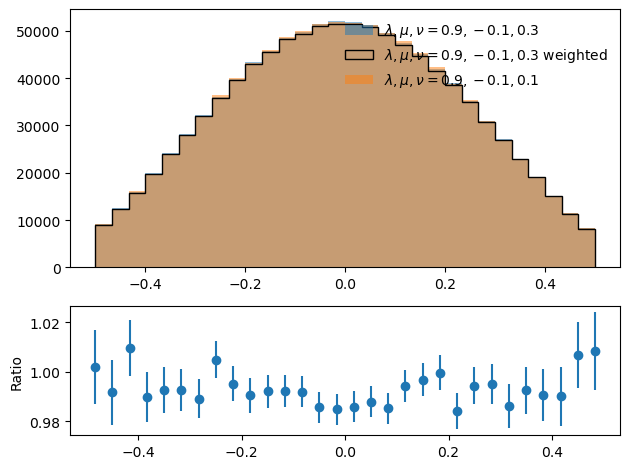

In [17]:
bins = np.linspace(-0.5, 0.5, 31)

plot_hist(X0[:, 1], X1[:, 1], weight0=weight0, weight1=weight1, weights=weights, bins=bins)

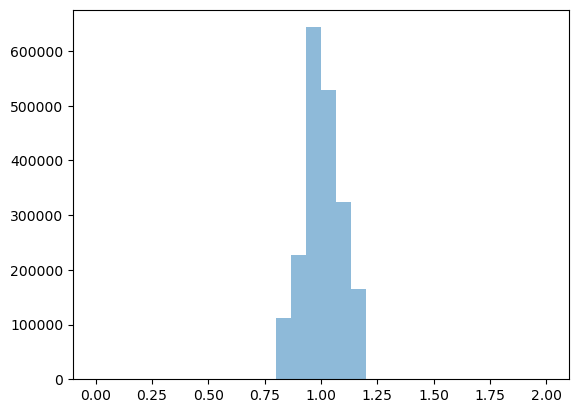

In [18]:
bins = np.linspace(0.0, 2.0, 31)
plt.hist(weight, bins=bins, alpha=0.5)
plt.show()